In [5]:
#install.packages("lmtest")
#install.packages("sandwich")
#install.packages("ggplot2")
#install.packages("dplyr")
#install.packages("hdm")
#install.packages("dagitty")
#install.packages("ggdag")
install.packages("igraph")

Installing package into 'C:/Users/vn.hoyosm/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)



package 'igraph' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\vn.hoyosm\AppData\Local\Temp\Rtmp8sXfMD\downloaded_packages


# Multicollinearity

## Introduction
**Multicollinearity** occurs when one or more predictor variables in a multiple regression model are highly correlated. This can significantly affect the accuracy of the coefficient estimates within the model.

## Mathematical Explanation

Consider the linear regression model:
$ Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + \ldots + \beta_kX_k + \epsilon $


where:
- $Y$ is the dependent variable
- $X_1, X_2, \ldots, X_k$ are the independent variables
- $\epsilon$ is the error term.

### Normal Equation
The coefficients $\beta$ are estimated using the equation:
$ \beta = (\mathbf{X}´\mathbf{X})^{-1}\mathbf{X}´\mathbf{Y} $

To find $\beta$, the matrix $\mathbf{X}´\mathbf{X}$ must be invertible. However, multicollinearity can make this matrix nearly singular or singular.


### Why $\mathbf{X}´\mathbf{X}$ Becomes Non-invertible
- **Singular Matrix**: If $\mathbf{X}´\mathbf{X}$ is singular, it implies that its determinant is zero due to perfect or high multicollinearity.
- **Linear Dependence**: This happens when one or more independent variables are linear combinations of others.


Matrix Representation

Assume $X_2 = cX_1$, then:
$ \mathbf{X} = \begin{bmatrix} 1 & X_1 & X_2 \\ 1 & X_1 & cX_1 \\ \vdots & \vdots & \vdots \\ 1 & X_1 & cX_1 \end{bmatrix} $


### Covariance Matrix ($\mathbf{X}´\mathbf{X}$)
$ \mathbf{X}´\mathbf{X} = \begin{bmatrix} n & \sum X_1 & c\sum X_1 \\ \sum X_1 & \sum X_1^2 & c\sum X_1^2 \\ c\sum X_1 & c\sum X_1^2 & c^2\sum X_1^2 \end{bmatrix} $


Here, the columns of $\mathbf{X}´\mathbf{X}$ are linear combinations of each other, which results in:
$ \text{det}(\mathbf{X}´\mathbf{X}) = 0 $
indicating that the matrix is not invertible due to multicollinearity.

###Example

**-Economic indicators** Predicting country's economic growth using both consumer spending and consumer income as predictors might lead to multicollinearity because these two are highly correlated; higher income generally leads to higher spending. Including both in the same regression model can cause issues in accurately estimating the impact of each predictor on economic growth.

**-Real Estate Pricing** In real estate, the size of a house and the number of rooms often exhibit multicollinearity. Both these variables tend to increase together; a larger house typically has more rooms. If both variables are used as predictors in a regression model to predict house prices, their high correlation can distort the individual effect of each variable on the pricing, making it difficult to assess which feature (size or number of rooms) truly impacts the house price.






### Testing for invertibility




In [6]:
# seed for reproducibility
set.seed(3)

A <- matrix(rnorm(100),ncol = 10)

#set last column is as a linear combination of last 3 columns
A[,10] = A[,1] * 2 + A[,8] * 3 + A[,9]



B<-solve(A)
B

ERROR: Error in solve.default(A): sistema es computacionalmente singular: número de condición recíproco = 3.54137e-18


Since we create a vector as the linear combination of 3 other vectors, the multicolinearity problem occurs, which prevents us from inverting the matrix.

# Analyzing RCT data with Precision Adjustment

In [7]:
## loading the data
Penn <- as.data.frame(read.table("../../../data/penn_jae.dat", header=T ))
n <- dim(Penn)[1]
p_1 <- dim(Penn)[2]
Penn<- subset(Penn, tg==2 | tg==0)
attach(Penn)

In [8]:
T2 <- (tg==2)
summary(T2)

   Mode   FALSE    TRUE 
logical    3354    2428 

In [9]:
head(Penn)

,abdt,tg,inuidur1,inuidur2,female,black,hispanic,othrace,dep,q1,⋯,q5,q6,recall,agelt35,agegt54,durable,nondurable,lusd,husd,muld
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,10824,0,18,18,0,0,0,0,2,0,⋯,1,0,0,0,0,0,0,0,1,0
2,10635,2,7,3,0,0,0,0,0,0,⋯,0,0,0,1,0,0,0,1,0,0
4,10824,0,1,1,0,0,0,0,0,0,⋯,1,0,0,0,0,0,0,1,0,0
5,10747,0,27,27,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,0,0
10,10754,2,20,20,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1
13,10831,0,27,27,0,0,0,0,1,0,⋯,1,0,0,0,1,1,0,1,0,0


In [10]:
#summarize variables 
#summary(Penn)

* #### **Histogram of the variable inuidur1 for treatment and control groups**


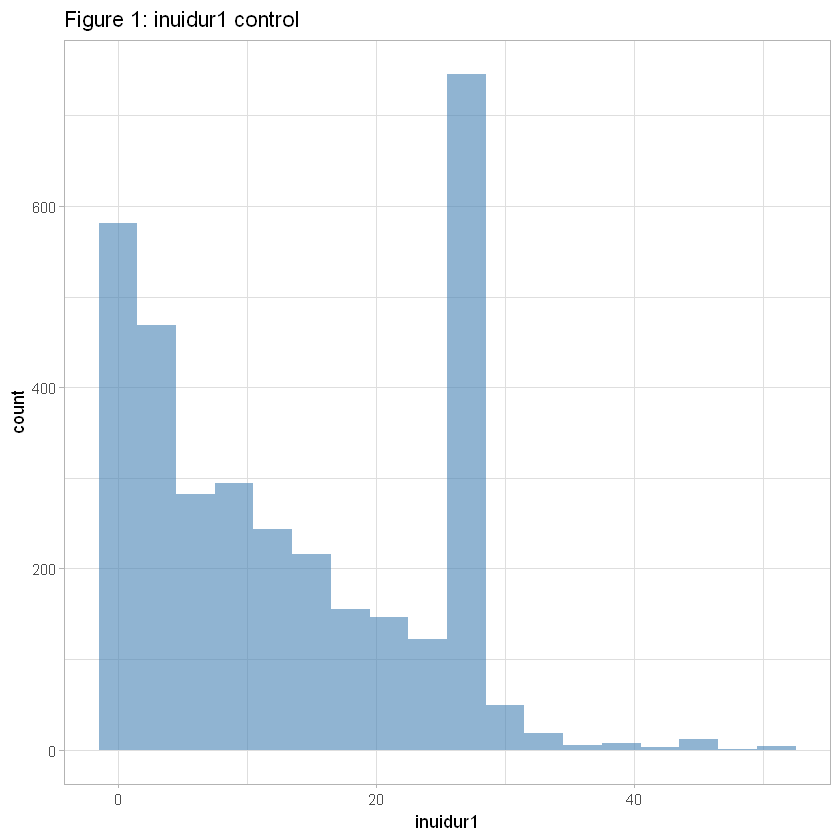

In [11]:
library(ggplot2)
controles <- ggplot(subset(Penn, tg==0), aes(inuidur1))  +
geom_histogram( binwidth = 3, fill = "steelblue", alpha = 0.6) +
ggtitle("Figure 1: inuidur1 control") +  
theme_light()
print(controles)    



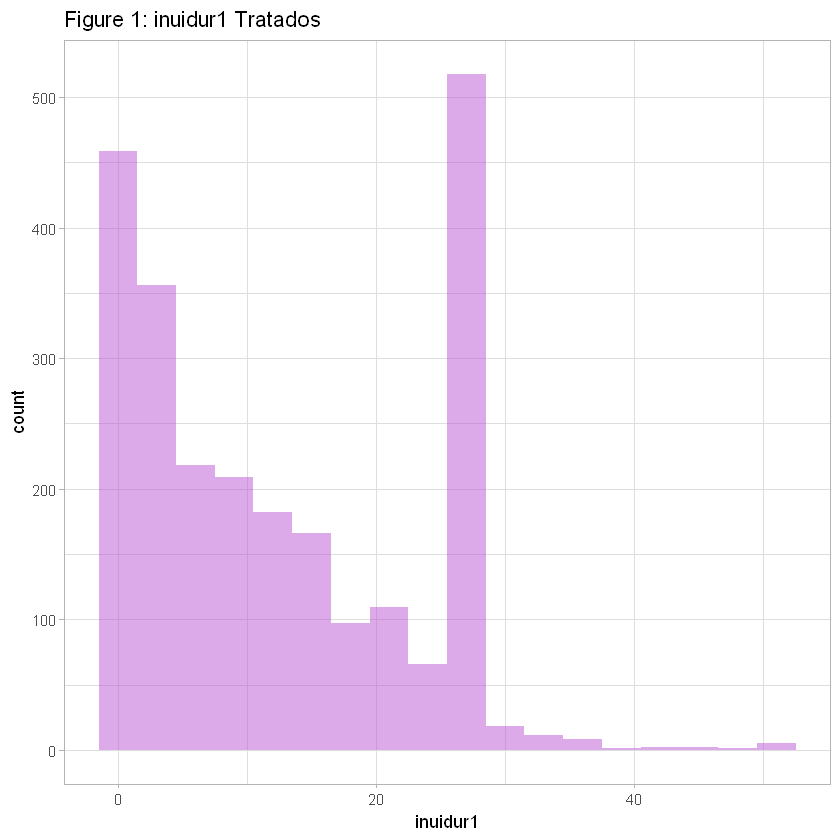

In [12]:
tratados <- ggplot(subset(Penn, tg==2), aes(inuidur1))  +
geom_histogram( binwidth = 3, fill = "MediumOrchid", alpha = 0.5) +
ggtitle("Figure 1: inuidur1 Tratados") +  
theme_light()
print(tratados)  

### Model 
To evaluate the impact of the treatments on unemployment duration, we consider the linear regression model:

$$
Y =  D \beta_1 + W'\beta_2 + \varepsilon, \quad E \varepsilon (D,W')' = 0,
$$

where $Y$ is  the  log of duration of unemployment, $D$ is a treatment  indicators,  and $W$ is a set of controls including age group dummies, gender, race, number of dependents, quarter of the experiment, location within the state, existence of recall expectations, and type of occupation.   Here $\beta_1$ is the ATE, if the RCT assumptions hold rigorously.


We also consider interactive regression model:

$$
Y =  D \alpha_1 + D W' \alpha_2 + W'\beta_2 + \varepsilon, \quad E \varepsilon (D,W', DW')' = 0,
$$
where $W$'s are demeaned (apart from the intercept), so that $\alpha_1$ is the ATE, if the RCT assumptions hold rigorously.

### Analysis

We consider 

*  classical 2-sample approach, no adjustment (CL)
*  classical linear regression adjustment (CRA)
*  interactive regression adjusment (IRA)

and carry out robust inference using the *estimatr* R packages. 

In [13]:
library(lmtest)
library(sandwich)

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric




In [14]:
# Variable T2  is random
m <- lm(T2~(female+black+othrace+factor(dep)+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd)^2)

coeftest(m, vcov = vcovHC(m, type="HC1"))


t test of coefficients:

                       Estimate Std. Error t value  Pr(>|t|)    
(Intercept)           0.5171342  0.1568823  3.2963 0.0009856 ***
female                0.0056240  0.1324597  0.0425 0.9661352    
black                -0.0307771  0.0847262 -0.3633 0.7164293    
othrace              -0.4278818  0.3005502 -1.4237 0.1545993    
factor(dep)1          0.1576567  0.1851798  0.8514 0.3945992    
factor(dep)2         -0.1927958  0.1508926 -1.2777 0.2014067    
q2                   -0.1092161  0.1583768 -0.6896 0.4904762    
q3                   -0.1075663  0.1579864 -0.6809 0.4959890    
q4                   -0.0621302  0.1581168 -0.3929 0.6943797    
q5                   -0.0498684  0.1575034 -0.3166 0.7515450    
q6                   -0.2176336  0.1558290 -1.3966 0.1625831    
agelt35              -0.0643464  0.1326376 -0.4851 0.6276032    
agegt54               0.0259251  0.2395371  0.1082 0.9138171    
durable              -0.1256397  0.1763853 -0.7123 0.4763064    

In [15]:
# get same dataframe

X <- as.data.frame( model.matrix(m) )

no_col <- attributes(m$coefficients)$names[is.na(m$coefficients)]

X1  <- X[, -which(names( X ) %in% no_col ) ]

save( X1, file = "../../../data/m_reg.RData")

### Model specifications
##### 1.1 No adjustment

In [16]:
# no adjustment (2-sample approach)
formula_cl <- log(inuidur1)~T2

# Omitted dummies: q1, nondurable, muld
ols.cl_reg <- lm(formula_cl)

ols.cl = coeftest(ols.cl_reg, vcov = vcovHC(ols.cl_reg, type="HC1"))
print(ols.cl)


t test of coefficients:

             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.056830   0.020954 98.1580  < 2e-16 ***
T2TRUE      -0.078825   0.032509 -2.4247  0.01535 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



##### 1.2 Classical linear regression adjustmen

In [17]:
# adding controls
formula_cra <- log(inuidur1)~T2+ (female+black+othrace+factor(dep)+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd)^2
# Omitted dummies: q1, nondurable, muld
ols.cra_reg <- lm(formula_cra)
ols.cra = coeftest(ols.cra_reg, vcov = vcovHC(ols.cra_reg, type="HC1"))
print(ols.cra)


t test of coefficients:

                       Estimate Std. Error t value  Pr(>|t|)    
(Intercept)           2.4471832  0.3580899  6.8340 9.123e-12 ***
T2TRUE               -0.0712066  0.0320440 -2.2222 0.0263124 *  
female               -0.9428048  0.2827961 -3.3339 0.0008620 ***
black                -0.6654258  0.2430567 -2.7377 0.0062056 ** 
othrace              -1.5494550  0.7312071 -2.1190 0.0341306 *  
factor(dep)1          0.2798498  0.3783316  0.7397 0.4595160    
factor(dep)2          0.1678164  0.3678718  0.4562 0.6482768    
q2                    0.0271228  0.3606226  0.0752 0.9400495    
q3                   -0.3542370  0.3601780 -0.9835 0.3254005    
q4                   -0.3380244  0.3606994 -0.9371 0.3487284    
q5                   -0.1777168  0.3598757 -0.4938 0.6214465    
q6                   -0.4456044  0.3612792 -1.2334 0.2174749    
agelt35              -0.3264815  0.3108711 -1.0502 0.2936639    
agegt54              -0.1551504  0.4796700 -0.3235 0.7463646    

In [18]:
# interactive regression model variables 
X <- model.matrix(~(female+black+othrace+factor(dep)+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd)^2)[,-1] #without intercept

The interactive specificaiton corresponds to the approach introduced in Lin (2013).

##### 1.3 Interactive regression adjustment (IRA)

In [19]:
#interactive regression model

demean<- function(x){ x - mean(x)}
X = apply(X, 2, demean)

ols.ira_reg = lm(log(inuidur1) ~ T2*X) 
ols.ira= coeftest(ols.ira_reg, vcov = vcovHC(ols.ira_reg, type="HC1"))
print(ols.ira)


t test of coefficients:

                               Estimate Std. Error t value  Pr(>|t|)    
(Intercept)                   2.0556976  0.0207138 99.2430 < 2.2e-16 ***
T2TRUE                       -0.0699044  0.0320764 -2.1793 0.0293503 *  
Xfemale                      -0.6662823  0.4080234 -1.6330 0.1025357    
Xblack                       -0.8634862  0.2969435 -2.9079 0.0036528 ** 
Xothrace                     -3.8176881  0.9366193 -4.0760 4.645e-05 ***
Xfactor(dep)1                 0.0359264  0.6476816  0.0555 0.9557666    
Xfactor(dep)2                 0.2117556  0.4512231  0.4693 0.6388790    
Xq2                          -0.2546436  0.4553391 -0.5592 0.5760207    
Xq3                          -0.6212326  0.4549639 -1.3655 0.1721653    
Xq4                          -0.4799269  0.4561206 -1.0522 0.2927566    
Xq5                          -0.3718675  0.4538882 -0.8193 0.4126542    
Xq6                          -0.6770474  0.4521499 -1.4974 0.1343469    
Xagelt35                 

In [20]:
ols_ira.female <- ols.ira["T2TRUE:Xfemale",1]
CI1upper <-confint(ols.ira)["T2TRUE:Xfemale",2]
CI1low <-confint(ols.ira)["T2TRUE:Xfemale",1]

ols_ira.black <- ols.ira["T2TRUE:Xblack",1]
CI2upper <-confint(ols.ira)["T2TRUE:Xblack",2]
CI2low <-confint(ols.ira)["T2TRUE:Xblack",1]

ols_ira.age <- ols.ira["T2TRUE:Xagelt35",1]
CI3upper <-confint(ols.ira)["T2TRUE:Xagelt35",2]
CI3low <-confint(ols.ira)["T2TRUE:Xagelt35",1]

ols_ira.dep1 <- ols.ira["T2TRUE:Xfactor(dep)1",1]
CI4upper <-confint(ols.ira)["T2TRUE:Xfactor(dep)1",2]
CI4low <-confint(ols.ira)["T2TRUE:Xfactor(dep)1",1]

##### 1.4 Interactive regression adjustment (IRA) using Lasso

In [21]:
T2 = demean(T2)
DX = model.matrix(~T2*X)[,-1]
head(DX)

,T2,Xfemale,Xblack,Xothrace,Xfactor(dep)1,Xfactor(dep)2,Xq2,Xq3,Xq4,Xq5,⋯,T2:Xagelt35:agegt54,T2:Xagelt35:durable,T2:Xagelt35:lusd,T2:Xagelt35:husd,T2:Xagegt54:durable,T2:Xagegt54:lusd,T2:Xagegt54:husd,T2:Xdurable:lusd,T2:Xdurable:husd,T2:Xlusd:husd
1,-0.4199239,-0.4007264,-0.118817,-0.005188516,-0.1165687,0.839329,-0.2001038,-0.2355586,-0.2232791,0.7367693,⋯,0,0.03086608,0.05563156,0.05120138,0.007916241,0.0136537,0.01162017,0.02309509,0.01220118,0
2,0.5800761,-0.4007264,-0.118817,-0.005188516,-0.1165687,-0.160671,-0.2001038,0.7644414,-0.2232791,-0.2632307,⋯,0,-0.04263790,0.50322755,-0.07072875,-0.010935367,-0.0188610,-0.01605192,-0.03190318,-0.01685451,0
3,-0.4199239,-0.4007264,-0.118817,-0.005188516,-0.1165687,-0.160671,-0.2001038,-0.2355586,-0.2232791,0.7367693,⋯,0,0.03086608,0.05563156,0.05120138,0.007916241,0.0136537,0.01162017,0.02309509,0.01220118,0
4,-0.4199239,-0.4007264,-0.118817,-0.005188516,-0.1165687,-0.160671,-0.2001038,-0.2355586,0.7767209,-0.2632307,⋯,0,0.03086608,0.05563156,0.05120138,0.007916241,0.0136537,0.01162017,0.02309509,0.01220118,0
5,0.5800761,0.5992736,-0.118817,-0.005188516,-0.1165687,-0.160671,-0.2001038,-0.2355586,0.7767209,-0.2632307,⋯,0,-0.04263790,-0.07684855,-0.07072875,-0.010935367,-0.0188610,-0.01605192,-0.03190318,-0.01685451,0
6,-0.4199239,-0.4007264,-0.118817,-0.005188516,0.8834313,-0.160671,-0.2001038,-0.2355586,-0.2232791,0.7367693,⋯,0,0.03086608,0.05563156,0.05120138,-0.412007661,-0.4062702,0.01162017,-0.39682881,0.01220118,0


In [22]:
library(hdm)

rlasso.ira = summary(rlassoEffects(DX, log(inuidur1), index = 1))

# rlassoEffects ( Partialling out )
# index = 1 (T4 treatment )
print(rlasso.ira)

[1] "Estimates and significance testing of the effect of target variables"
   Estimate. Std. Error t value Pr(>|t|)  
T2  -0.07457    0.03209  -2.324   0.0201 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1




In [23]:
# getting data
S = as.data.frame(DX)
save( S, file = "../../../data/rlasso_ira_reg.RData")

In [24]:
head(S)

,T2,Xfemale,Xblack,Xothrace,Xfactor(dep)1,Xfactor(dep)2,Xq2,Xq3,Xq4,Xq5,⋯,T2:Xagelt35:agegt54,T2:Xagelt35:durable,T2:Xagelt35:lusd,T2:Xagelt35:husd,T2:Xagegt54:durable,T2:Xagegt54:lusd,T2:Xagegt54:husd,T2:Xdurable:lusd,T2:Xdurable:husd,T2:Xlusd:husd
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.4199239,-0.4007264,-0.118817,-0.005188516,-0.1165687,0.839329,-0.2001038,-0.2355586,-0.2232791,0.7367693,⋯,0,0.03086608,0.05563156,0.05120138,0.007916241,0.0136537,0.01162017,0.02309509,0.01220118,0
2,0.5800761,-0.4007264,-0.118817,-0.005188516,-0.1165687,-0.160671,-0.2001038,0.7644414,-0.2232791,-0.2632307,⋯,0,-0.04263790,0.50322755,-0.07072875,-0.010935367,-0.0188610,-0.01605192,-0.03190318,-0.01685451,0
3,-0.4199239,-0.4007264,-0.118817,-0.005188516,-0.1165687,-0.160671,-0.2001038,-0.2355586,-0.2232791,0.7367693,⋯,0,0.03086608,0.05563156,0.05120138,0.007916241,0.0136537,0.01162017,0.02309509,0.01220118,0
4,-0.4199239,-0.4007264,-0.118817,-0.005188516,-0.1165687,-0.160671,-0.2001038,-0.2355586,0.7767209,-0.2632307,⋯,0,0.03086608,0.05563156,0.05120138,0.007916241,0.0136537,0.01162017,0.02309509,0.01220118,0
5,0.5800761,0.5992736,-0.118817,-0.005188516,-0.1165687,-0.160671,-0.2001038,-0.2355586,0.7767209,-0.2632307,⋯,0,-0.04263790,-0.07684855,-0.07072875,-0.010935367,-0.0188610,-0.01605192,-0.03190318,-0.01685451,0
6,-0.4199239,-0.4007264,-0.118817,-0.005188516,0.8834313,-0.160671,-0.2001038,-0.2355586,-0.2232791,0.7367693,⋯,0,0.03086608,0.05563156,0.05120138,-0.412007661,-0.4062702,0.01162017,-0.39682881,0.01220118,0


### Results

In [25]:
install.packages("xtable")
library(xtable)
table<- matrix(0, 2, 4)
table[1,1]<-  ols.cl[2,1]
table[1,2]<-  ols.cra[2,1]
table[1,3]<-  ols.ira[2,1]
table[1,4]<-  rlasso.ira[[1]][1]

table[2,1]<-  ols.cl[2,2]
table[2,2]<-  ols.cra[2,2]
table[2,3]<-  ols.ira[2,2]
table[2,4]<-  rlasso.ira[[1]][2]


colnames(table)<- c("CL","CRA","IRA", "IRA w Lasso")
rownames(table)<- c("estimate", "standard error")
tab<- xtable(table, digits=5)
tab

print(tab, type="latex", digits=5)

Installing package into 'C:/Users/vn.hoyosm/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)



package 'xtable' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\vn.hoyosm\AppData\Local\Temp\Rtmp8sXfMD\downloaded_packages


,CL,CRA,IRA,IRA w Lasso
,<dbl>,<dbl>,<dbl>,<dbl>
estimate,-0.07882533,-0.07120664,-0.06990440,-0.07457328
standard error,0.03250889,0.03204403,0.03207638,0.03208892


% latex table generated in R 4.3.3 by xtable 1.8-4 package
% Wed Apr 24 14:43:29 2024
\begin{table}[ht]
\centering
\begin{tabular}{rrrrr}
  \hline
 & CL & CRA & IRA & IRA w Lasso \\ 
  \hline
estimate & -0.07883 & -0.07121 & -0.06990 & -0.07457 \\ 
  standard error & 0.03251 & 0.03204 & 0.03208 & 0.03209 \\ 
   \hline
\end{tabular}
\end{table}


* #### **Using the 3. interactive regression adjustment (IRA) plot the coefficients of the next variables**

In [26]:
CIdf <- data.frame(x = c('T2*female','T2*black','T2*agelt35','T2*factor(dep)1'),
                         y = c(ols_ira.female, ols_ira.black,ols_ira.age, ols_ira.dep1),
                         lower = c(CI1low,CI2low,CI3low,CI4low),
                         upper = c(CI1upper,CI2upper,CI3upper,CI4upper))

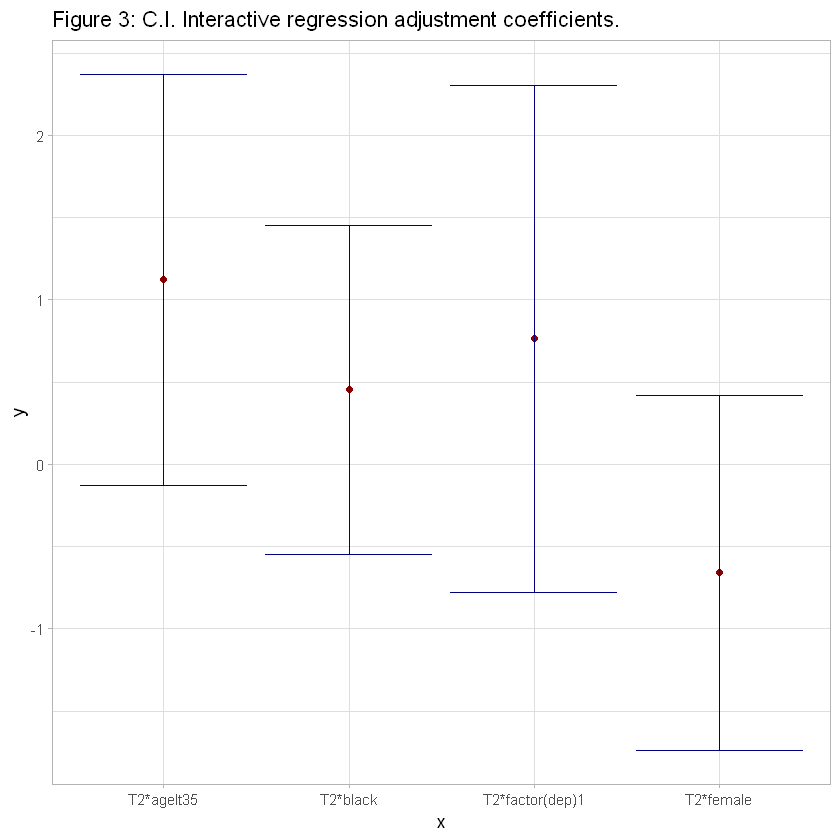

In [27]:
ggplot(CIdf, aes(x, y)) +
  geom_point(color = "darkred") +  
  geom_errorbar(aes(ymin = lower, ymax = upper), color = "navyblue") +  
  ggtitle("Figure 3: C.I. Interactive regression adjustment coefficients.") +
  theme_light()
     

# A Crash Course in Good and Bad Controls

In this section, we will cover various models that illustrate "good" and "bad" controls within statistical analyses. These terms refer to the effects of adding a variable to a regression model—whether such inclusion results in discrepancies or aids interpretation of the model. For a more detailed exploration of these concepts, you are encouraged to review the full text available in the technical report [here](https://ftp.cs.ucla.edu/pub/stat_ser/r493.pdf).


#Good Controls 1 (blocking back-door paths)
###MODEL 1
In this case, we want to measure the effect of hours of study ($X$) on students' academic performance as measured by final grades ($Y$). If we run the regression without taking into account nutrition ($Z$), which affects both $X$ and $Y$, the coefficients will be biased. By including $Z$ in the model, a cleaner effect of hours of study on final grades can be obtained, approaching 1, which is the true parameter ( $\approx1$).


Attaching package: 'igraph'


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union




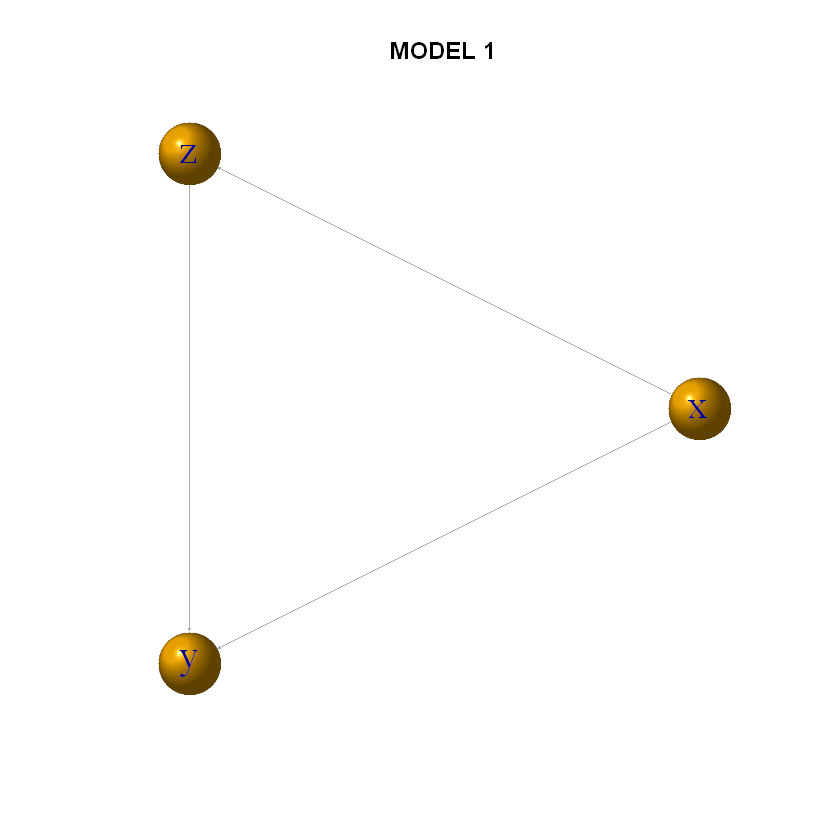

In [28]:
library(igraph)
# Create a directed graph with specified edges and number of vertices
sprinkle <- graph(edges = c(1, 2, 1, 3, 2, 3), n = 3, directed = TRUE)

# Assign names to the vertices
V(sprinkle)$name <- c("x", "z", "y")

# Plot the graph in a circular layout
plot(sprinkle, layout = layout.circle,vertex.size = 25, # Increases the size of the vertices
     edge.arrow.size = 0.1,#Change the size of the arrowheads
     vertex.colour = "skyblue", # Vertex label colour
     vertex.label.colour = "red", # Colour of the vertex label
     vertex.label.cex = 2, # Increases the size of the vertex label
     vertex.label.label.family = "Helvetica", # Label font type
     edge.width = 0.3, # Edge thickness
     edge.colour = "blue", # Border colour
     vertex.shape = "sphere",
     main = "MODEL 1") # GRAPH TITLE


In [29]:
# Set Seed
# To make the results replicable (generating random numbers)
set.seed(1234567)

# Generate data
n <- 1000
Z <- matrix(rnorm(n, mean = 0, sd = 1), ncol = 1)
X <- 2 * Z + matrix(rnorm(n, mean = 0, sd = 1), ncol = 1)
Y <- X + Z + matrix(rnorm(n, mean = 0, sd = 1), ncol = 1)

# Create dataframe
data <- data.frame(Z = Z, X = X, Y = Y)

In [30]:
# Regressions
no_control <- lm(Y ~ X, data = data)
using_control <- lm(Y ~ X + Z, data = data)

# Summary results
summary(no_control)
summary(using_control)


Call:
lm(formula = Y ~ X, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.4825 -0.7057 -0.0475  0.7142  4.3064 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.003953   0.034892  -0.113     0.91    
X            1.402810   0.015884  88.314   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.103 on 998 degrees of freedom
Multiple R-squared:  0.8866,	Adjusted R-squared:  0.8864 
F-statistic:  7799 on 1 and 998 DF,  p-value: < 2.2e-16



Call:
lm(formula = Y ~ X + Z, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2981 -0.6776 -0.0586  0.6585  3.3177 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.01069    0.03202  -0.334    0.739    
X            1.00757    0.03227  31.222   <2e-16 ***
Z            0.97774    0.07123  13.727   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.012 on 997 degrees of freedom
Multiple R-squared:  0.9046,	Adjusted R-squared:  0.9044 
F-statistic:  4726 on 2 and 997 DF,  p-value: < 2.2e-16


###Model 2

In this case we want to see how much anti-corruption laws($X$) affect the number of corruption cases($Y$). But there is an unobservable variable that affects both, which is the feeling of injustice, which drives criminality and increases the number of laws. Then, we control for the number of active judges($Z$) to clean up the effect of the unobservable on my X. Finally controlling, my coefficient is close to my variable ($\approx 0.5$).



Warning message in text.default(x, y, labels = labels, col = label.color, family = label.family, :
"font family not found in Windows font database"


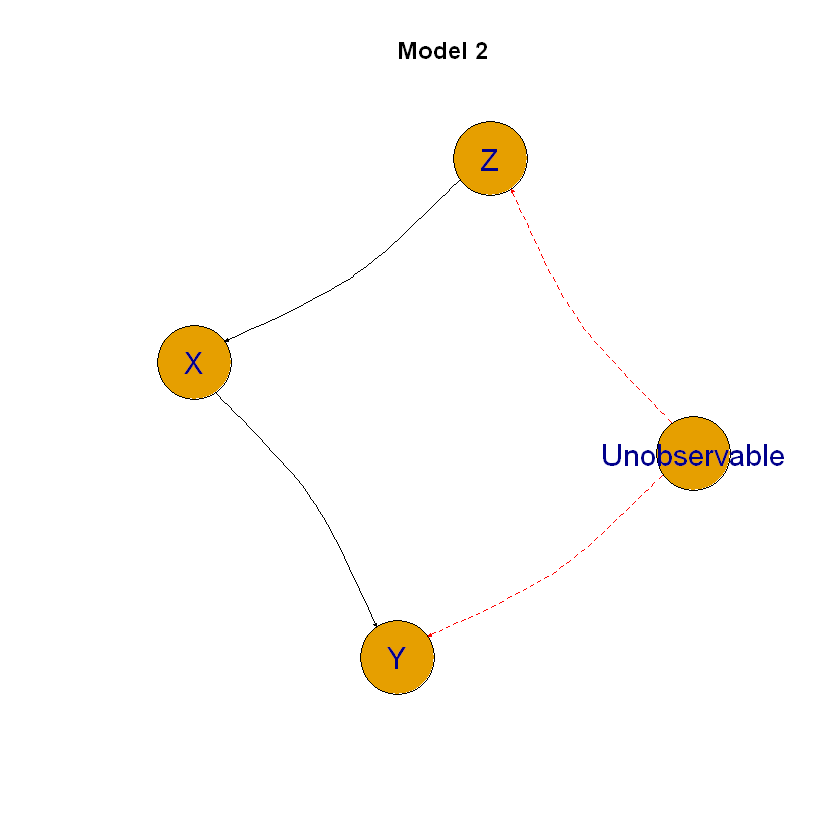

In [31]:
# Define nodes and edges including latent edges as different style.
edges <- c("Z", "X", "X", "Y", "Latent", "Z", "Latent", "Y")
edge_types <- c("observed", "observed", "latent", "latent")

# Create the graph
sprinkler <- graph(edges, directed = TRUE)

# Set vertex names
V(sprinkler)$name <- c("Z", "X", "Y", "Unobservable")

# Assign edge types (latent or observed)
E(sprinkler)$type <- edge_types

# Define edge style based on type
E(sprinkler)$color <- ifelse(E(sprinkler)$type == "observed", "black", "red")
E(sprinkler)$arrow.size <- 0.1
E(sprinkler)$arrow.width <- 2
E(sprinkler)$lty <- ifelse(E(sprinkler)$type == "observed", 1, 2) # Solid for observed, dashed for latent

# Plot graph with curves and customisations
plot(sprinkler, layout = layout_nicely(sprinkler),
     vertex.size = 30, # Adjust size of vertices
     vertex.colour = "skyblue", # Set vertex colour
     vertex.label.colour = "black", # Set the vertex label colour
     vertex.label.cex = 1.5, # Sets the font size of the vertex label
     vertex.label.family = "Helvetica", # Sets the label's font family
     edge.curved = 0.2, # Adjust the curvature of the edges
     main = "Model 2") #GRAPH TITLE

In [32]:
# Set Seed
# To make the results replicable (generating random numbers)
set.seed(1234567)

# Generate data
n <- 1000
U <- matrix(rnorm(n, mean = 0, sd = 1), ncol = 1)
Z <- 3 * U + matrix(rnorm(n, mean = 0, sd = 1), ncol = 1)
X <- Z + matrix(rnorm(n, mean = 0, sd = 1), ncol = 1)
Y <- 0.5 * X + 2 * U + matrix(rnorm(n, mean = 0, sd = 1), ncol = 1)

# Create dataframe
data <- data.frame(U = U, Z = Z, X = X, Y = Y)




In [33]:
# Regressions
no_control <- lm(Y ~ X, data = data)
using_control <- lm(Y ~ X + Z, data = data)

# Summary results
summary(no_control)
summary(using_control)


Call:
lm(formula = Y ~ X, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7309 -0.9189 -0.0846  0.9308  4.8195 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.05425    0.04278  -1.268    0.205    
X            1.04629    0.01307  80.036   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.353 on 998 degrees of freedom
Multiple R-squared:  0.8652,	Adjusted R-squared:  0.8651 
F-statistic:  6406 on 1 and 998 DF,  p-value: < 2.2e-16



Call:
lm(formula = Y ~ X + Z, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.8194 -0.8272 -0.1053  0.8398  4.4475 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.05880    0.03822  -1.539    0.124    
X            0.47369    0.03781  12.530   <2e-16 ***
Z            0.63207    0.03969  15.925   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.209 on 997 degrees of freedom
Multiple R-squared:  0.8925,	Adjusted R-squared:  0.8923 
F-statistic:  4140 on 2 and 997 DF,  p-value: < 2.2e-16


#Bad Control (M-bias)

###MODEL 7

Now, if we want to study how education($X$) affects diabetes($Y$) we could adjust for the mother's diabetes status($Z$) and consider it a confounder. However, this association is not direct, and adjusting for the mother will open up an association with income during childhood($U_1$) and overall risk of diabetes ($U_2$).

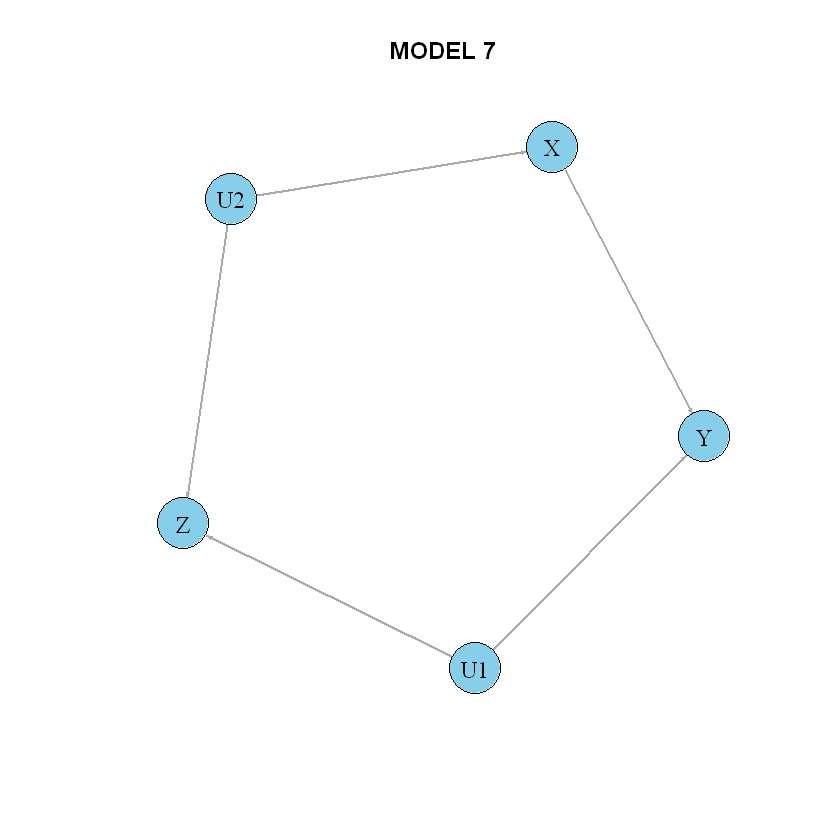

In [34]:
# Define nodes and edges
edges <- c("U1", "Z", "U2", "Z", "U2", "X", "U1", "Y", "X", "Y")

# Create the directed graph with nodes and edges defined
sprinkle <- graph(edges, directed = TRUE)

# Set names for the vertices if needed (optional since they are defined in edges)
V(sprinkle)$name <- c("U1", "Z", "U2", "X", "Y")

# Plot the graph with customizations
plot(sprinkle, layout = layout_nicely(sprinkle),
     vertex.size = 20,            # Adjusts the size of the vertices
     vertex.color = "skyblue",    # Sets the vertex color
     vertex.label.color = "black", # Sets the vertex label color
     vertex.label.cex = 1.2,      # Adjusts the font size of vertex labels
     edge.arrow.size = 0.2,       # Adjusts the size of the arrows to be smaller
     edge.width = 2,              # Adjusts the thickness of the edges
     main = "MODEL 7") # Graph title


In [35]:
# Set Seed
# To make the results replicable (generating random numbers)
set.seed(12345676)

# Generate data
n <- 1000
U_1 <- matrix(rnorm(n, mean = 0, sd = 1), ncol = 1)
U_2 <- matrix(rnorm(n, mean = 0, sd = 1), ncol = 1)

Z <- U_1 + U_2 + matrix(rnorm(n, mean = 0, sd = 1), ncol = 1)
X <- 1.5 * U_1 + matrix(rnorm(n, mean = 0, sd = 1), ncol = 1)
Y <- X + 2.5 * U_2 + matrix(rnorm(n, mean = 0, sd = 1), ncol = 1)

# Create dataframe
data <- data.frame(U_1 = U_1, U_2 = U_2, Z = Z, X = X, Y = Y)



In [36]:
# Regressions
no_control <- lm(Y ~ X, data = data)
using_control <- lm(Y ~ X + Z, data = data)

# Summary results
summary(no_control)
summary(using_control)


Call:
lm(formula = Y ~ X, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.1907 -1.7167 -0.0141  1.7659  7.8172 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.05503    0.08605   0.639    0.523    
X            0.98486    0.04902  20.092   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.72 on 998 degrees of freedom
Multiple R-squared:  0.288,	Adjusted R-squared:  0.2873 
F-statistic: 403.7 on 1 and 998 DF,  p-value: < 2.2e-16



Call:
lm(formula = Y ~ X + Z, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.4769 -1.4166  0.0225  1.4589  7.7379 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.05301    0.06689   0.792    0.428    
X            0.50418    0.04248  11.868   <2e-16 ***
Z            1.07251    0.04192  25.588   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.114 on 997 degrees of freedom
Multiple R-squared:  0.5702,	Adjusted R-squared:  0.5694 
F-statistic: 661.4 on 2 and 997 DF,  p-value: < 2.2e-16


#Neutral Control (possibly good for precision)

###Model 8

In this case, we want to estimate how the introduction of a new smart learning programme ($X$) affects the academic performance of students ($Y$). When we run this regression, our estimator is unbiased. However, if we include the attendance rate ($Z$), which also affects performance, we can increase the precision of the estimator and still remain unbiased and increase the precision.

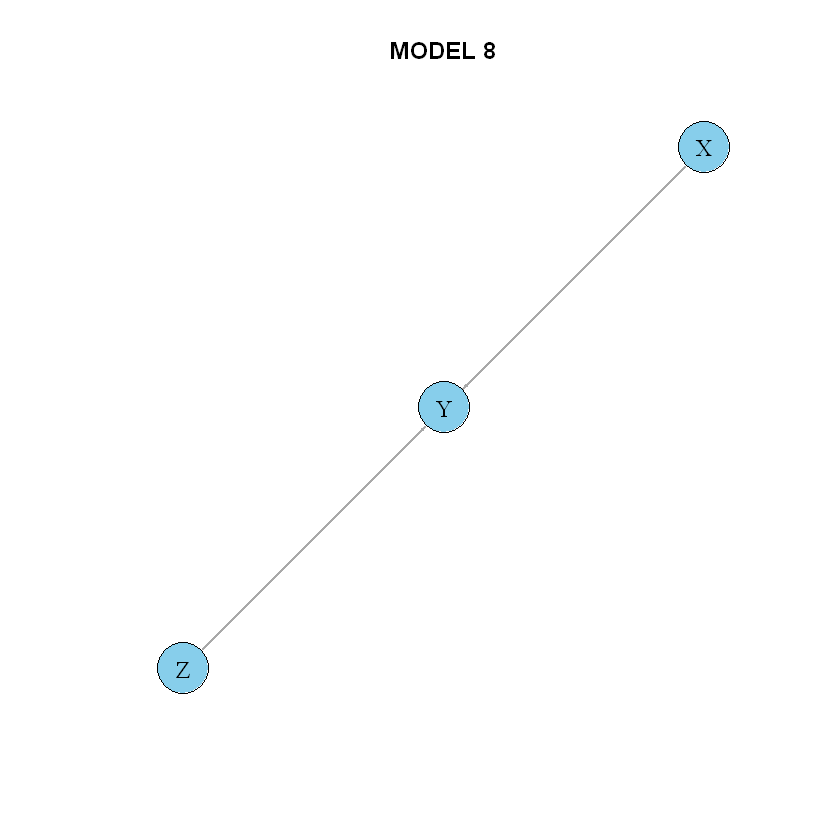

In [37]:
# Define nodes and edges
edges <- c("X", "Y", "Z", "Y")

# Create the directed graph with nodes and edges defined
sprinkle <- graph(edges, directed = TRUE)

# Set names for the vertices if needed (optional since they are defined in edges)
V(sprinkle)$name <- c("X", "Y", "Z")

# Plot the graph with customizations
plot(sprinkle, layout = layout_nicely(sprinkle),
     vertex.size = 20,            # Adjusts the size of the vertices
     vertex.color = "skyblue",    # Sets the vertex color
     vertex.label.color = "black", # Sets the vertex label color
     vertex.label.cex = 1.2,      # Adjusts the font size of vertex labels
     edge.arrow.size = 0.2,       # Adjusts the size of the arrows to be smaller
     edge.width = 2,              # Adjusts the thickness of the edges
     main = "MODEL 8") # Graph title


In [38]:
# Set Seed
# To make the results replicable (generating random numbers)
set.seed(12345676)

# Generate data
n <- 1000
Z <- matrix(rnorm(n, mean = 0, sd = 1), ncol = 1)
X <- matrix(rnorm(n, mean = 0, sd = 1), ncol = 1)
Y <- X + 1.5 * Z + matrix(rnorm(n, mean = 0, sd = 1), ncol = 1)

# Create dataframe
data <- data.frame(Z = Z, X = X, Y = Y)



In [39]:
# Regressions
no_control <- lm(Y ~ X, data = data)
using_control <- lm(Y ~ X + Z, data = data)

# Summary results
summary(no_control)
summary(using_control)



Call:
lm(formula = Y ~ X, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.6349 -1.2718  0.0289  1.2724  5.0490 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.01047    0.05674   0.185    0.854    
X            1.06537    0.05512  19.330   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.794 on 998 degrees of freedom
Multiple R-squared:  0.2724,	Adjusted R-squared:  0.2717 
F-statistic: 373.6 on 1 and 998 DF,  p-value: < 2.2e-16



Call:
lm(formula = Y ~ X + Z, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.5100 -0.6873  0.0084  0.6944  3.2094 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.02095    0.03132  -0.669    0.504    
X            1.00564    0.03045  33.030   <2e-16 ***
Z            1.55237    0.03252  47.738   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9901 on 997 degrees of freedom
Multiple R-squared:  0.7786,	Adjusted R-squared:  0.7781 
F-statistic:  1753 on 2 and 997 DF,  p-value: < 2.2e-16


#Bad Controls (Overcontrol Bias)

###Model 11

In this case we want to analyse how the growth of the city in terms of urban infrastructure (residential areas, shopping centres, etc.) impacts on the level of vehicle congestion ($Y$). Now, if we add a variable such as the number of cars ($Z$) that is affected by the infrastructure, but not vice versa and that causes a higher level of congestion, we would be removing the explanatory power of $X$. Now by controlling for both variables, the estimator of X loses significance and moves away from its true estimator ($\neq1$).


In [40]:
# Define nodes and edges
edges <- c("X", "Z", "Z", "Y")

# Create the directed graph with nodes and edges defined
sprinkle <- graph(edges, directed = TRUE)

# Set names for the vertices
V(sprinkle)$name <- c("X", "Z", "Y")

# Plot the graph with customizations
plot(sprinkle, layout = layout_nicely(sprinkle),
     vertex.size = 20,            # Adjusts the size of the vertices
     vertex.color = "skyblue",    # Sets the vertex color
     vertex.label.color = "black", # Sets the vertex label
     vertex.label.cex = 1.2,      # Adjusts the font size of vertex labels
     edge.arrow.size = 0.2,       # Adjusts the size of the arrows to be smaller
     edge.width = 2,              # Adjusts the thickness of the edges
     main = "MODEL 11") # Graph title

ERROR: Error in V()$name <- c("X", "Z", "Y"): lado izquierdo de la asignación inválida (NULL)


In [41]:
# Set Seed
# To make the results replicable (generating random numbers)
set.seed(1234567)

# Generate data
n <- 1000
X <- matrix(rnorm(n, mean = 0, sd = 1), ncol = 1) # Generate X
Z <- 1.3 * X + matrix(rnorm(n, mean = 0, sd = 1), ncol = 1) # Generate Z
Y <- Z + matrix(rnorm(n, mean = 0, sd = 1), ncol = 1) # Generate Y

# Create dataframe
data <- data.frame(Z = Z, X = X, Y = Y)

In [42]:
# Regressions
no_control <- lm(Y ~ X, data = data)
using_control <- lm(Y ~ X + Z, data = data)

# Summary results
summary(no_control)
summary(using_control)


Call:
lm(formula = Y ~ X, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.1327 -0.9115  0.0324  0.8743  5.3061 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.02939    0.04500  -0.653    0.514    
X            1.26186    0.04522  27.908   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.423 on 998 degrees of freedom
Multiple R-squared:  0.4383,	Adjusted R-squared:  0.4378 
F-statistic: 778.8 on 1 and 998 DF,  p-value: < 2.2e-16



Call:
lm(formula = Y ~ X + Z, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2981 -0.6776 -0.0586  0.6585  3.3177 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.01069    0.03202  -0.334    0.739    
X           -0.01696    0.05208  -0.326    0.745    
Z            1.00757    0.03227  31.222   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.012 on 997 degrees of freedom
Multiple R-squared:  0.716,	Adjusted R-squared:  0.7154 
F-statistic:  1257 on 2 and 997 DF,  p-value: < 2.2e-16
